# 1. Setup and Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 2. Download 25+ Years of Data for SPY, QQQ, DIA

In [2]:
tickers = ['SPY', 'QQQ', 'DIA', '^VIX']
start_date = "2000-01-01"
end_date = "2025-05-31"

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Check data

In [4]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2000-01-03,92.414948,94.202087,91.422092,94.202087,8164300
2000-01-04,88.800949,91.541229,88.731449,91.203658,8089800
2000-01-05,88.959816,89.932814,87.212391,88.920102,12177900
2000-01-06,87.530106,89.912958,87.530106,88.721532,6227200
2000-01-07,92.613495,92.613495,88.999503,89.158360,8066500


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300
2025-05-30,589.390015,591.130005,583.239990,588.929993,90601200


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2000-01-03,80.314316,81.532805,76.923738,81.532805,36345200
2000-01-04,74.804581,79.254712,74.539692,77.983246,33786600
2000-01-05,72.897408,75.970118,71.414030,74.168874,42496600
2000-01-06,67.891006,74.592694,67.599629,73.639094,37134800
2000-01-07,76.287971,76.287971,69.930641,70.301485,28138200


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300
2025-05-30,519.109985,520.679993,511.929993,519.440002,67662800


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2000-01-03,65.827797,67.295873,65.537807,67.295873,1278800
2000-01-04,63.661972,65.519724,63.661972,65.120987,1535700
2000-01-05,64.486641,65.175368,63.236057,63.797913,2007000
2000-01-06,64.812889,65.637550,64.486650,64.613521,2639500
2000-01-07,66.987808,67.024057,65.664727,65.719100,3767400


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,DIA,DIA,DIA,DIA,DIA
Date,,,,,
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400
2025-05-30,422.850006,424.269989,419.510010,422.160004,2957500


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 3. Calculate Technical Indicators (RSI, MACD, TSI, etc.)

In [5]:
import ta

def add_indicators(df):
    df = df.copy()

    close = df['Close'].squeeze()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

    # MACD components
    macd = ta.trend.MACD(close=close)
    df['MACD_Line'] = macd.macd()
    df['Signal_Line'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()

    # EMAs for reference
    df['EMA_3'] = ta.trend.EMAIndicator(close=close, window=3).ema_indicator()
    df['EMA_5'] = ta.trend.EMAIndicator(close=close, window=5).ema_indicator()

    return df

Add custom indicator TSI (Trend Strength Index) from TradingView

In [6]:
def trend_strength_index(close_prices, window=14):
    tsi_values = []
    close_array = close_prices.squeeze().astype(float).values  # Ensure 1D array

    for i in range(len(close_array)):
        if i + 1 < window:
            tsi_values.append(np.nan)
        else:
            price_window = close_array[i + 1 - window: i + 1]  # include index i
            index_window = np.arange(window)
            r, _ = pearsonr(index_window, price_window)
            tsi_values.append(r)

    return pd.Series(tsi_values, index=close_prices.index)

Apply TSI to each dataset (SPY, QQQ, DIA)

In [7]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]
    df = add_indicators(df)
    df['TSI'] = trend_strength_index(df['Close'], window=14)
    data[ticker] = df

Add VIX values to each dataset (SPY, QQQ, DIA)

In [8]:
# Ensure VIX is aligned by date and rename the close column for clarity
vix_data = data['^VIX'][['Close']].rename(columns={'Close': 'VIX'})

for ticker in ['SPY', 'QQQ', 'DIA']:
    df = data[ticker]

    # Merge VIX values using the index (which should be the date)
    df = df.merge(vix_data, left_index=True, right_index=True, how='left')

    # Store the updated DataFrame back into your dictionary
    data[ticker] = df

Add Next Day's Return Column

In [9]:
for ticker in ['SPY', 'QQQ', 'DIA']:
    
    df = data[ticker]
    df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
    df.dropna(inplace=True)
    data[ticker] = df

In [10]:
for ticker in data:
    print(f"=== {ticker} - First 5 rows ===")
    display(data[ticker].head())
    
    print(f"=== {ticker} - Last 5 rows ===")
    display(data[ticker].tail())

=== SPY - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,85.981209,88.244917,85.544353,88.244917,9409200,36.234401,-0.892217,-0.585327,-0.306889,87.157031,87.753212,-0.723620,26.000000,-0.002540
2000-02-22,85.762825,86.636538,84.849398,85.901825,16415400,35.654895,-1.063746,-0.681011,-0.382735,86.459928,87.089750,-0.837683,25.860001,0.011808
2000-02-23,86.775490,87.351345,85.464922,86.179777,12119000,40.413857,-1.105231,-0.765855,-0.339376,86.617709,86.984996,-0.904489,23.889999,-0.020137
2000-02-24,85.028069,87.073349,84.571355,86.854921,17375000,35.530538,-1.264534,-0.865591,-0.398943,85.822889,86.332687,-0.919248,24.379999,-0.003619
2000-02-25,84.720337,86.874833,84.591266,85.901835,10559900,34.734551,-1.399481,-0.972369,-0.427112,85.271613,85.795237,-0.935399,25.200001,0.020977


=== SPY - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,SPY,SPY,SPY,SPY,SPY,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,583.090027,586.619995,581.409973,582.659973,70860400,59.499778,10.879004,9.581684,1.297320,585.461492,586.369279,0.808336,20.280001,-0.006826
2025-05-23,579.109985,581.809998,575.599976,575.979980,76029000,56.292174,9.910020,9.647351,0.262669,582.285739,583.949514,0.686693,22.290001,0.020791
2025-05-27,591.150024,591.309998,578.429993,586.070007,72588500,62.821677,9.998368,9.717554,0.280814,586.717881,586.349684,0.620869,18.959999,-0.005785
2025-05-28,587.729980,592.770020,586.989990,591.559998,68445500,60.076236,9.680822,9.710208,-0.029386,587.223931,586.809783,0.491271,19.309999,0.003947
2025-05-29,590.049988,593.200012,586.070007,593.059998,69973300,61.311410,9.506781,9.669523,-0.162742,588.636959,587.889851,0.342391,19.180000,-0.001119


=== QQQ - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,83.439941,87.307316,83.439941,86.989450,25271200,53.291485,1.841864,1.762699,0.079165,84.580139,84.718743,0.692834,26.000000,0.003175
2000-02-22,83.704834,84.711411,81.585724,83.916745,37226200,53.801499,1.698847,1.749928,-0.051082,84.142487,84.380773,0.509472,25.860001,0.055697
2000-02-23,88.366928,89.002661,84.049239,84.492928,32170800,61.723183,1.939341,1.787811,0.151530,86.254707,85.709492,0.477296,23.889999,0.021582
2000-02-24,90.274101,90.532368,86.459703,88.896680,48868200,64.411572,2.257801,1.881809,0.375992,88.264404,87.231028,0.524095,24.379999,-0.022887
2000-02-25,88.207993,91.121770,88.049059,90.009237,32617600,59.533320,2.316759,1.968799,0.347960,88.236198,87.556683,0.504658,25.200001,-0.000601


=== QQQ - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,514.000000,517.710022,512.299988,513.659973,55607200,64.287173,13.604804,11.898940,1.705864,515.338819,515.575589,0.844457,20.280001,-0.009261
2025-05-23,509.239990,511.839996,505.579987,506.179993,58368100,60.139417,12.657579,12.050668,0.606911,512.289404,513.463723,0.750104,22.290001,0.023525
2025-05-27,521.219971,521.710022,514.590027,516.150024,47226300,66.072422,12.726872,12.185909,0.540964,516.754688,516.049139,0.696755,18.959999,-0.004432
2025-05-28,518.909973,523.679993,518.390015,522.179993,46637200,64.091481,12.451854,12.239098,0.212756,517.832330,517.002750,0.601718,19.309999,0.001966
2025-05-29,519.929993,526.479980,517.320007,526.330017,58513300,64.596238,12.175851,12.226448,-0.050598,518.881162,517.978498,0.479277,19.180000,-0.001577


=== DIA - First 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2000-02-18,59.415367,61.013335,59.270097,61.013335,1526700,30.331991,-1.251038,-1.014620,-0.236419,60.320138,60.775256,-0.904344,26.000000,0.005501
2000-02-22,59.742199,60.123532,58.688993,59.778516,1518800,32.677190,-1.321853,-1.076066,-0.245787,60.031168,60.430904,-0.914344,25.860001,-0.005471
2000-02-23,59.415367,60.141716,59.052193,59.833018,1558900,31.534021,-1.388343,-1.138522,-0.249822,59.723268,60.092392,-0.926346,23.889999,-0.002446
2000-02-24,59.270061,59.669553,57.853681,59.596918,4518700,31.014535,-1.436206,-1.198059,-0.238148,59.496665,59.818282,-0.922106,24.379999,-0.033701
2000-02-25,57.272579,58.961339,57.054675,58.452896,3316900,24.933664,-1.616682,-1.281783,-0.334899,58.384622,58.969714,-0.913469,25.200001,0.016012


=== DIA - Last 5 rows ===


Price,Close,High,Low,Open,Volume,RSI,MACD_Line,Signal_Line,MACD_Histogram,EMA_3,EMA_5,TSI,VIX,Return
Ticker,DIA,DIA,DIA,DIA,DIA,,,,,,,,^VIX,
Date,,,,,,,,,,,,,,
2025-05-22,418.820007,421.149994,417.369995,417.869995,2638600,54.260049,4.640880,3.894686,0.746195,420.723628,421.575427,0.730394,20.280001,-0.005945
2025-05-23,416.329987,418.170013,413.829987,413.940002,3117800,51.650940,4.050888,3.925926,0.124962,418.526807,419.826947,0.562244,22.290001,0.018063
2025-05-27,423.850006,423.859985,419.190002,420.700012,3126600,58.189708,4.142367,3.969214,0.173153,421.188407,421.167967,0.464270,18.959999,-0.005733
2025-05-28,421.420013,424.829987,420.739990,423.730011,1790900,55.574225,3.972987,3.969969,0.003018,421.304210,421.251982,0.289062,19.309999,0.002468
2025-05-29,422.459991,423.019989,418.579987,422.459991,2751400,56.475878,3.877966,3.951568,-0.073602,421.882101,421.654652,0.122473,19.180000,0.000923


=== ^VIX - First 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2000-01-03,24.209999,26.150000,23.980000,24.360001,0
2000-01-04,27.010000,27.180000,24.799999,24.940001,0
2000-01-05,26.410000,29.000000,25.850000,27.980000,0
2000-01-06,25.730000,26.709999,24.700001,26.680000,0
2000-01-07,21.719999,25.170000,21.719999,25.139999,0


=== ^VIX - Last 5 rows ===


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2025-05-23,22.290001,25.530001,19.830000,20.139999,0
2025-05-27,18.959999,21.010000,18.950001,20.629999,0
2025-05-28,19.309999,19.430000,18.680000,19.209999,0
2025-05-29,19.180000,20.200001,18.110001,18.250000,0
2025-05-30,18.570000,20.549999,18.570000,19.610001,0


# 4. Correlation Analysis

=== Correlation Analysis for SPY ===


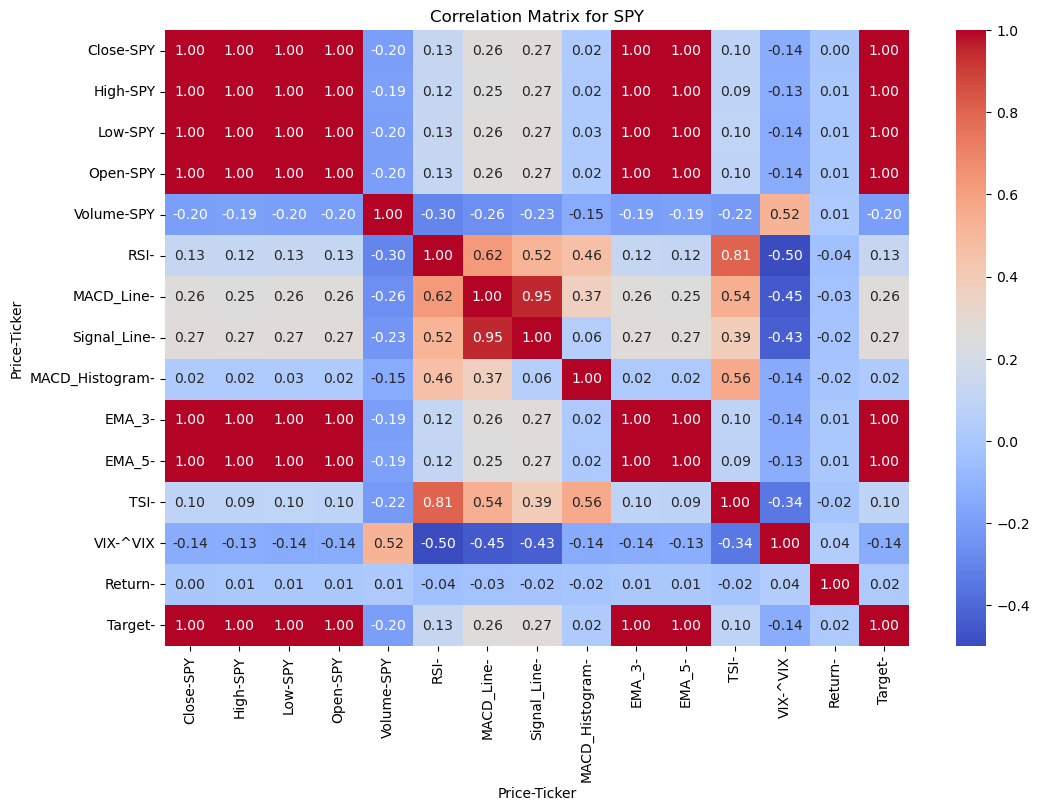

=== Correlation Analysis for QQQ ===


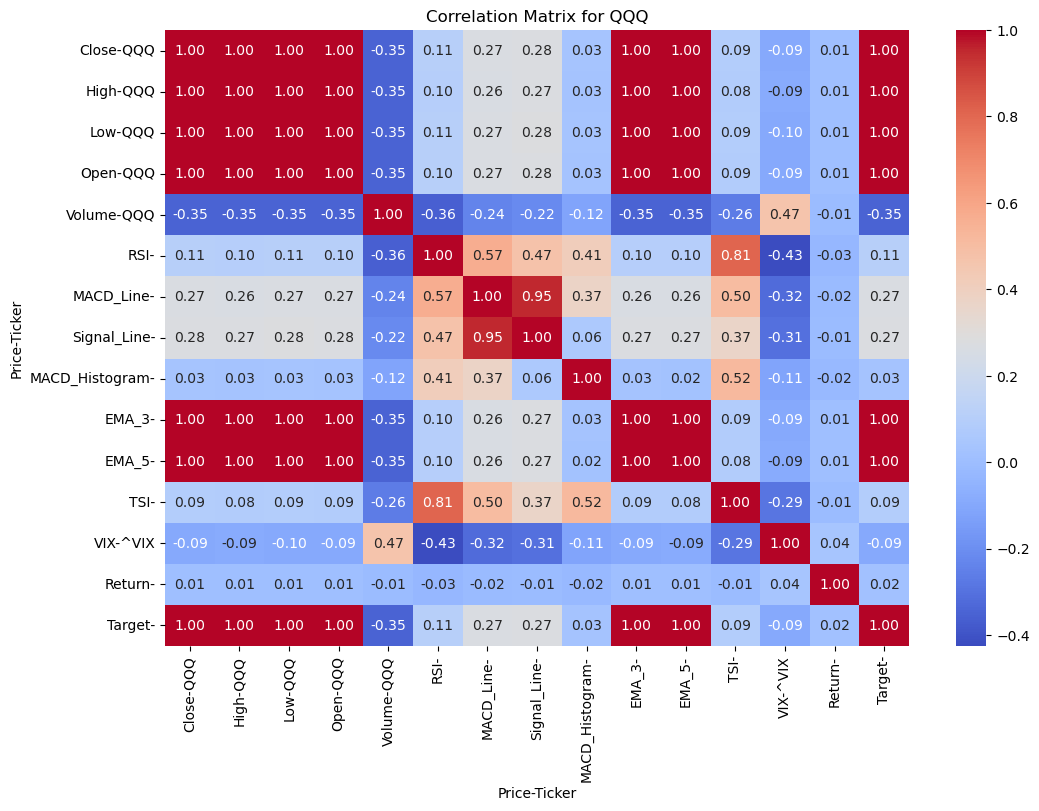

=== Correlation Analysis for DIA ===


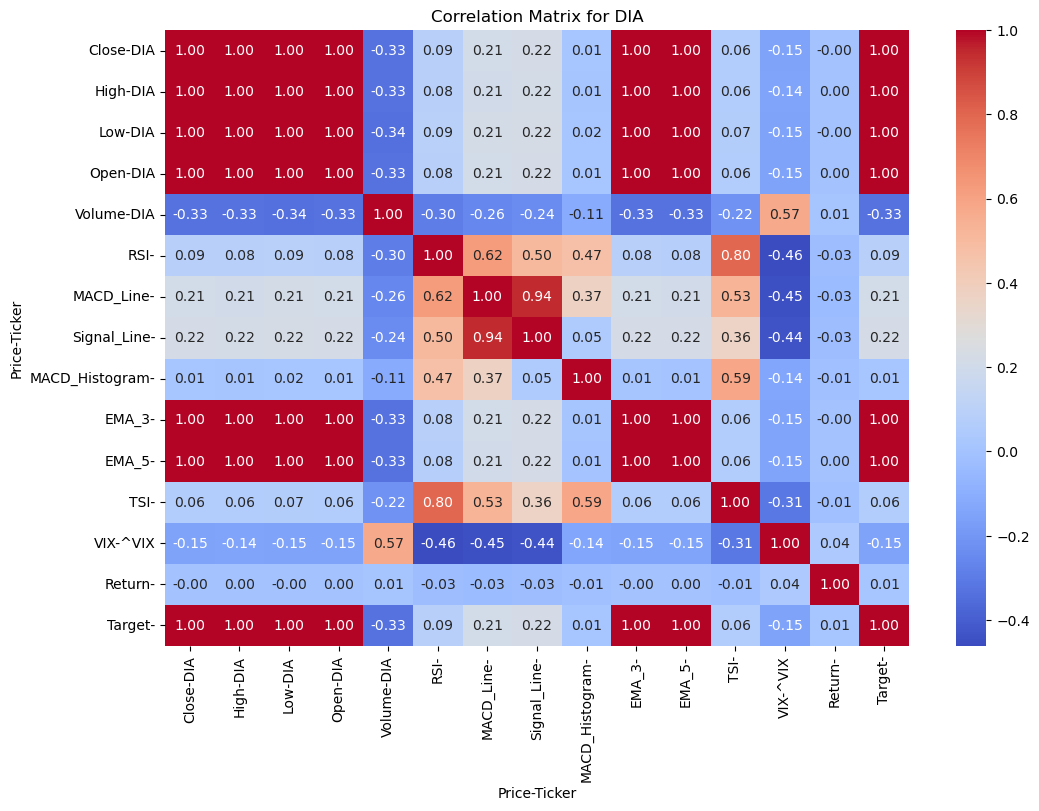

In [11]:
# Function to compute and plot correlation matrix
def plot_correlation_matrix(df, ticker):
    df = df.copy()
    
    # Drop rows with NaN values (especially from indicators and shift)
    df.dropna(inplace=True)
    
    # Add the target column (next day's closing price)
    df['Target'] = df['Close'].shift(-1)

    # Re-drop last row (now has NaN in Target)
    df.dropna(inplace=True)

    # Compute correlation matrix
    correlation = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f'Correlation Matrix for {ticker}')
    plt.show()

# Apply to all 3 tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"=== Correlation Analysis for {ticker} ===")
    plot_correlation_matrix(data[ticker], ticker)

# 5. Flatten MultiIndex Columns for Training

In [12]:
# ----------------------------
# A) FLATTEN MultiIndex columns
# ----------------------------
df_flat = data['SPY']  # or whatever ticker
df_flat.columns = df_flat.columns.get_level_values(0)
# Now df_flat.columns might look like:
#   ['Close','High','Low','Open','Volume','RSI','MACD_Line','Signal_Line','MACD_Histogram',
#    'EMA_3','EMA_5','TSI','VIX','Return']
#
# Replace data['SPY'] with this flattened version:
data['SPY'] = df_flat.copy()

# Repeat for QQQ and DIA:
for ticker in ['QQQ','DIA']:
    df_flat = data[ticker]
    df_flat.columns = df_flat.columns.get_level_values(0)
    data[ticker] = df_flat.copy()


# 6. Train XGBoost Model



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=2.21, SE=4.86, APE=0.83%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.44, SE=2.06, APE=0.46%, R²_so_far=0.9602
Trained through 2021-02-19, forecasted 2021-02-22, AE=3.11, SE=9.65, APE=0.85%, R²_so_far=0.9753
Trained through 2021-07-14, forecasted 2021-07-15, AE=8.84, SE=78.13, APE=2.15%, R²_so_far=0.9861
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.72, SE=13.87, APE=0.85%, R²_so_far=0.9907
Trained through 2022-04-28, forecasted 2022-04-29, AE=7.68, SE=58.99, APE=1.95%, R²_so_far=0.9923
Trained through 2022-09-21, forecasted 2022-09-22, AE=0.63, SE=0.39, APE=0.17%, R²_so_far=0.9918
Trained through 2023-02-14, forecasted 2023-02-15, AE=1.23, SE=1.51, APE=0.31%, R²_so_far=0.9916
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.82, SE=0.67, APE=0.19%, R²_so_far=0.9919
Trained through 2023-11-30, forecasted 2023-12-01, AE=1

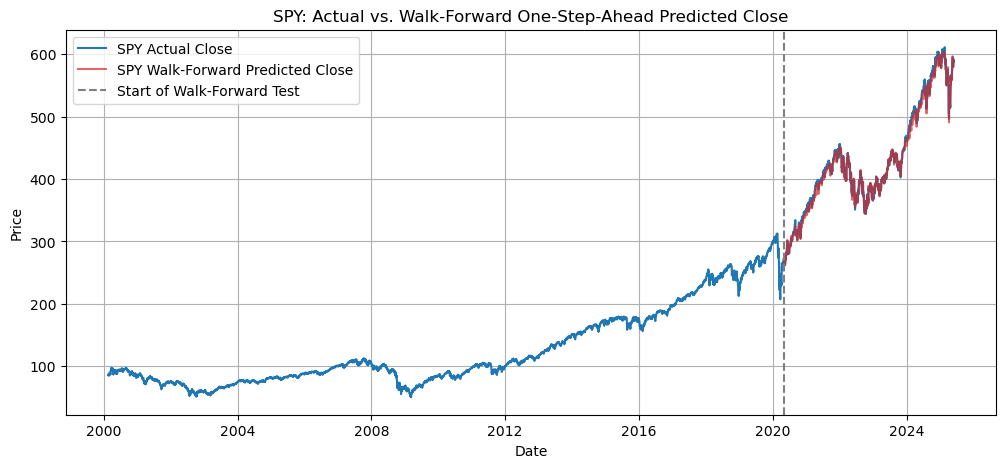

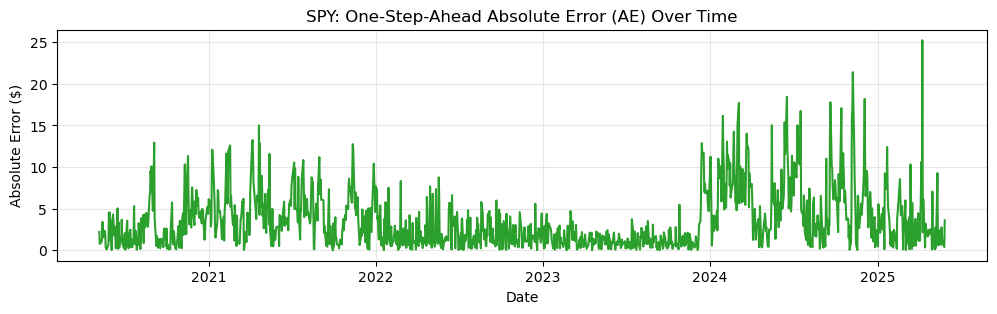

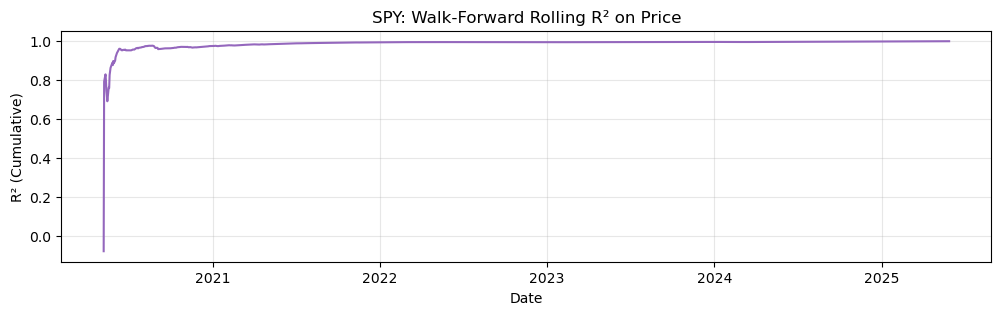



=== TICKER: QQQ ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.24, SE=0.06, APE=0.11%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=1.01, SE=1.02, APE=0.38%, R²_so_far=0.8719
Trained through 2021-02-19, forecasted 2021-02-22, AE=0.13, SE=0.02, APE=0.04%, R²_so_far=0.9552
Trained through 2021-07-14, forecasted 2021-07-15, AE=11.30, SE=127.60, APE=3.21%, R²_so_far=0.9740
Trained through 2021-12-03, forecasted 2021-12-06, AE=12.25, SE=150.14, APE=3.25%, R²_so_far=0.9842
Trained through 2022-04-28, forecasted 2022-04-29, AE=1.53, SE=2.34, APE=0.50%, R²_so_far=0.9860
Trained through 2022-09-21, forecasted 2022-09-22, AE=4.93, SE=24.30, APE=1.79%, R²_so_far=0.9861
Trained through 2023-02-14, forecasted 2023-02-15, AE=2.42, SE=5.87, APE=0.80%, R²_so_far=0.9873
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.44, SE=0.20, APE=0.12%, R²_so_far=0.9879
Trained through 2023-11-30, forecasted 2023-12-01, 

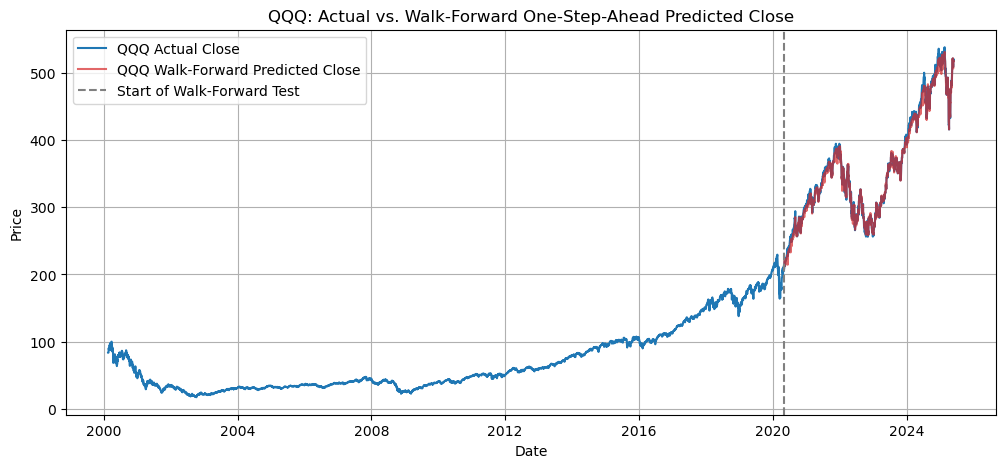

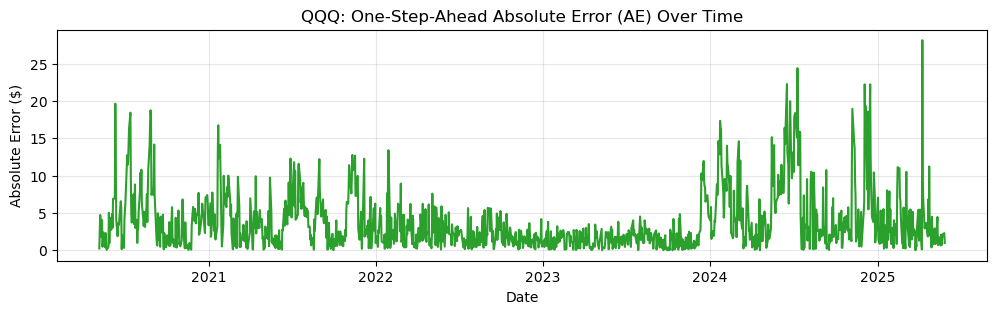

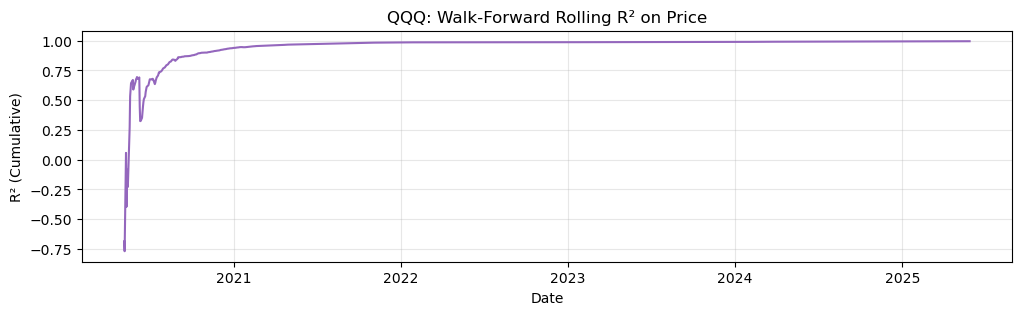



=== TICKER: DIA ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=0.47, SE=0.22, APE=0.22%, R²_so_far=nan
Trained through 2020-09-25, forecasted 2020-09-28, AE=0.37, SE=0.14, APE=0.15%, R²_so_far=0.9831
Trained through 2021-02-19, forecasted 2021-02-22, AE=4.01, SE=16.07, APE=1.37%, R²_so_far=0.9817
Trained through 2021-07-14, forecasted 2021-07-15, AE=2.80, SE=7.85, APE=0.86%, R²_so_far=0.9886
Trained through 2021-12-03, forecasted 2021-12-06, AE=3.45, SE=11.92, APE=1.04%, R²_so_far=0.9919
Trained through 2022-04-28, forecasted 2022-04-29, AE=5.93, SE=35.15, APE=1.90%, R²_so_far=0.9929
Trained through 2022-09-21, forecasted 2022-09-22, AE=1.53, SE=2.35, APE=0.53%, R²_so_far=0.9925
Trained through 2023-02-14, forecasted 2023-02-15, AE=0.27, SE=0.08, APE=0.08%, R²_so_far=0.9928
Trained through 2023-07-11, forecasted 2023-07-12, AE=0.60, SE=0.36, APE=0.18%, R²_so_far=0.9931
Trained through 2023-11-30, forecasted 2023-12-01, AE=1

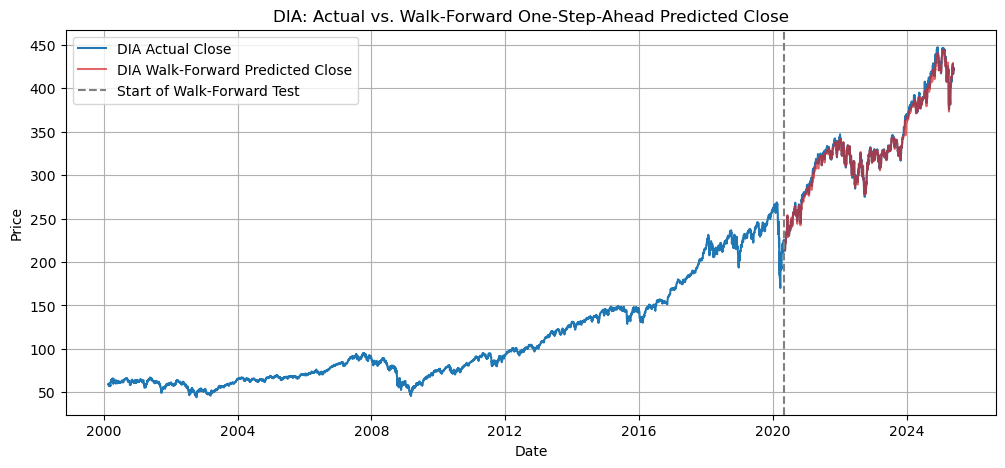

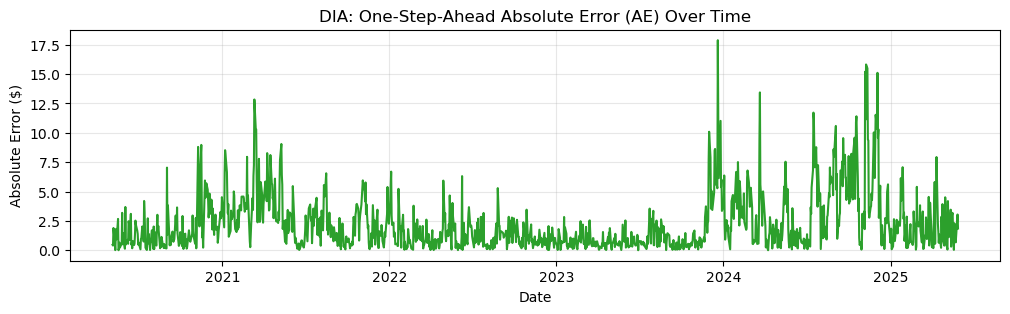

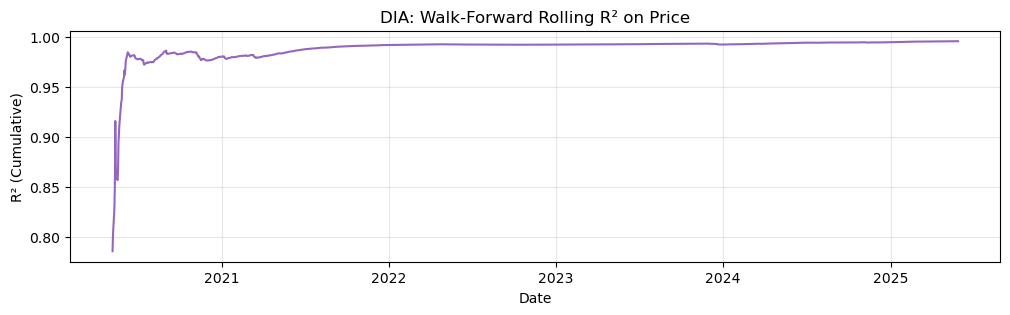

In [13]:
# List of tickers to process
tickers = ['SPY', 'QQQ', 'DIA']

# Features to use at each time t
features = [
    'Close','Open','High','Low','Volume',
    'EMA_3','EMA_5',
    'RSI','MACD_Histogram','TSI','VIX'
]

for ticker in tickers:
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()   # assume already flattened

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e. the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all   = df[features].values        # shape = (N, n_features)
    y_all   = df['TargetClose'].values    # shape = (N,)
    dates   = df.index                    # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk   = pd.Series(data=np.nan, index=dates)   # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()                    # actual Close[t]

    #  We will store one‐step‐ahead errors (AE, SE, APE, R²) in lists
    ae_list   = []   # absolute error = |y_true - y_pred|
    se_list   = []   # squared error  = (y_true - y_pred)^2
    ape_list  = []   # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list   = []   # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) WALK‐FORWARD LOOP (EXPANDING WINDOW)
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(day_idx)       # [0, 1, …, day_idx-1]
        test_idx  = day_idx                  # single integer

        X_train = X_all[train_idx, :]        # features rows 0…day_idx-1
        y_train = y_all[train_idx]           # targets rows 0…day_idx-1

        X_test  = X_all[test_idx:test_idx+1, :]
        # shape = (1, n_features): features of row “day_idx” (to predict Close at day_idx+1)

        # (B.2) Scale features (fit on train, transform test)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # (B.3) Train XGBoost to predict TargetClose = Close(t+1)
        model = XGBRegressor(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=5,
            gamma=1,
            objective='reg:squarederror',
            random_state=42,
            verbosity=0
        )
        model.fit(X_train_scaled, y_train)

        # (B.4) One‐step‐ahead forecast: predict Close for next day
        y_pred_next_close = model.predict(X_test_scaled)[0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.5) Record errors for this “held‐out day_idx” 
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day   = abs(actual_c - y_pred_next_close)                   # absolute error
        se_day   = (actual_c - y_pred_next_close) ** 2                  # squared error
        ape_day  = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.6) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far     = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a small DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date'    : date_list,
        'AE'      : ae_list,
        'SE'      : se_list,
        'APE'     : ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics:
    mean_mae   = np.mean(errors_df['AE'])
    mean_mse   = np.mean(errors_df['SE'])
    mean_rmse  = np.sqrt(mean_mse)
    mean_mape  = np.mean(errors_df['APE'])
    final_r2   = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12,5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12,3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()

# 7. LSTM Model

In [14]:
# 7. LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define sequence length for LSTM
timesteps = 30

def create_sequences(X, y, timesteps):
    """
    Create 3D sequences for LSTM input and corresponding targets.
    Returns: X_seq (n_samples, timesteps, n_features), y_seq (n_samples,)
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define LSTM model architecture once, outside the loop
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(timesteps, len(features))),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single scalar for next-day Close
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Store initial weights to reset model each iteration
initial_weights = model.get_weights()

for ticker in tickers[:3]:  # Exclude ^VIX since it's a feature, not a target
    print(f"\n\n=== TICKER: {ticker} ===")

    # ──────────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT-DAY ‘CLOSE’ FORECASTING
    # ──────────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()

    # 2) Create the next-day-close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e., the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk-forward
    X_all = df[features].values  # shape = (N, n_features)
    y_all = df['TargetClose'].values  # shape = (N,)
    dates = df.index  # DatetimeIndex length = N

    # 5) Compute initial-train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk = pd.Series(data=np.nan, index=dates)  # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()  # actual Close[t]

    # Lists to store one-step-ahead errors
    ae_list = []  # absolute error = |y_true - y_pred|
    se_list = []  # squared error = (y_true - y_pred)^2
    ape_list = []  # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list = []  # rolling R² (cumulative)
    date_list = []

    # ──────────────────────────────────────────────────────────────
    # (B) WALK-FORWARD LOOP (EXPANDING WINDOW)
    # ──────────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train-block [0 … day_idx-1] and test-point = day_idx
        train_idx = np.arange(timesteps, day_idx)  # Start from timesteps to allow sequence creation
        test_idx = day_idx  # single integer

        X_train = X_all[:day_idx, :]  # features rows 0…day_idx-1
        y_train = y_all[:day_idx]  # targets rows 0…day_idx-1
        X_test = X_all[day_idx-timesteps:day_idx+1, :]  # sequence for prediction

        # (B.2) Scale features and target
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
        
        # Fit scalers on training data only
        X_train_scaled = feature_scaler.fit_transform(X_train)
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        
        # Transform test sequence
        X_test_scaled = feature_scaler.transform(X_test)

        # (B.3) Create sequences for LSTM
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq = X_test_scaled[-timesteps:].reshape(1, timesteps, len(features))

        # (B.4) Reset model weights and train LSTM model
        model.set_weights(initial_weights)  # Reset to initial weights
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # (B.5) One-step-ahead forecast: predict Close for next day
        y_pred_scaled = model.predict(X_test_seq, verbose=0)[0, 0]
        y_pred_next_close = target_scaler.inverse_transform([[y_pred_scaled]])[0, 0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.6) Record errors for this ‘held-out day_idx’
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day = abs(actual_c - y_pred_next_close)  # absolute error
        se_day = (actual_c - y_pred_next_close) ** 2  # squared error
        ape_day = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.7) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ──────────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ──────────────────────────────────────────────────────────────

    # Build a DataFrame of the walk-forward errors
    errors_df = pd.DataFrame({
        'Date': date_list,
        'AE': ae_list,
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics
    mean_mae = np.mean(errors_df['AE'])
    mean_mse = np.mean(errors_df['SE'])
    mean_rmse = np.sqrt(mean_mse)
    mean_mape = np.mean(errors_df['APE'])
    final_r2 = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK-FORWARD SUMMARY <<<")
    print(f"One-step-ahead MAE:    {mean_mae:.4f}")
    print(f"One-step-ahead MSE:    {mean_mse:.4f}")
    print(f"One-step-ahead RMSE:   {mean_rmse:.4f}")
    print(f"One-step-ahead MAPE:   {mean_mape:.2f}%")
    print(f"One-step-ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk-forward)
    plt.figure(figsize=(12, 5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk-Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk-Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk-Forward One-Step-Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day-by-day AE (MAE) over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One-Step-Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk-Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()



=== TICKER: SPY ===
Total days: 6,356   |   Initial train size: 5,084
Trained through 2020-05-05, forecasted 2020-05-06, AE=13.19, SE=173.86, APE=4.99%, R²_so_far=nan


KeyboardInterrupt: 

# Fixed LSTM (Remove Retraining Every Day)



=== SPY ===
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0151
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.0536e-04
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.1482e-04
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.6766e-04
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.4642e-04
MAE: 40.1192, MSE: 2300.8162, RMSE: 47.9668, R²: 0.6686


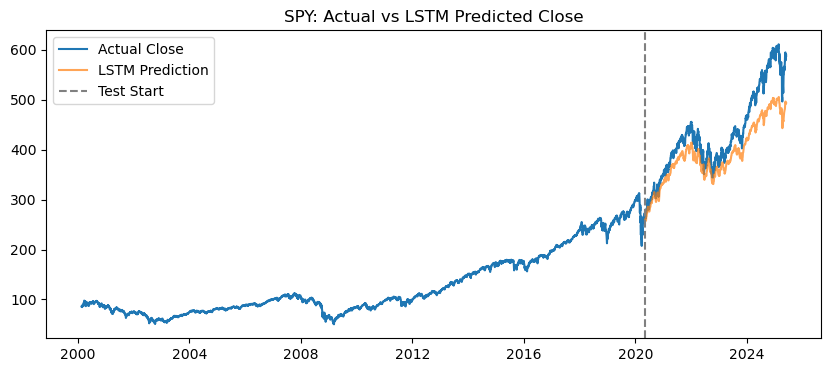



=== QQQ ===
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0286
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.3682e-04
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.5041e-04
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.7421e-04
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.2304e-04
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4327e-04
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.9780e-04
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.0310e-04
MAE: 63.8007, MSE: 6015.5312, RMSE: 77.5599, R²: 0.0677


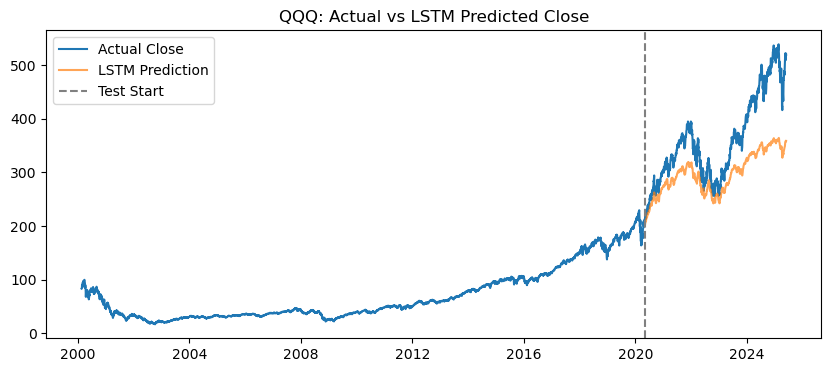



=== DIA ===
Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0184
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.9701e-04
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4052e-04
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7338e-04
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2866e-04
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.2947e-04
MAE: 38.1396, MSE: 1824.0728, RMSE: 42.7092, R²: 0.3229


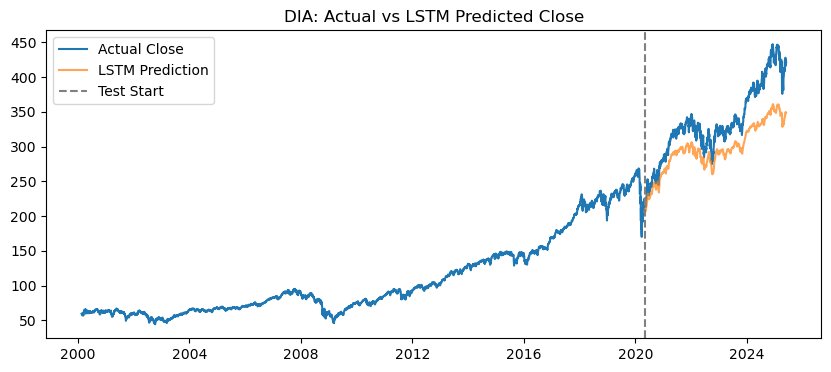

In [20]:
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1) LSTM settings
timesteps = 100
train_frac = 0.8
epochs = 10
batch_size = 64

# 2) Build a fresh LSTM model
def build_model(n_features):
    m = Sequential([
        LSTM(64, input_shape=(timesteps, n_features)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

# 3) Loop over tickers
for ticker in ['SPY', 'QQQ', 'DIA']:
    print(f"\n\n=== {ticker} ===")
    df = data[ticker].copy()
    df['TargetClose'] = df['Close'].shift(-1)
    df.dropna(subset=['TargetClose'], inplace=True)
    
    X = df[features].values
    y = df['TargetClose'].values
    dates = df.index
    N = len(df)
    split = int(train_frac * N)
    
    # 4) Scale on training block
    feat_scaler = MinMaxScaler().fit(X[:split])
    targ_scaler = MinMaxScaler().fit(y[:split].reshape(-1,1))
    Xs = feat_scaler.transform(X)
    ys = targ_scaler.transform(y.reshape(-1,1)).ravel()
    
    # 5) Build sequences for training
    X_train_seq, y_train_seq = [], []
    for i in range(timesteps, split):
        X_train_seq.append(Xs[i-timesteps:i])
        y_train_seq.append(ys[i])
    X_train_seq = np.array(X_train_seq)
    y_train_seq = np.array(y_train_seq)
    
    # 6) Train once
    model = build_model(X.shape[1])
    model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # 7) Walk-forward forecasting without retraining
    window = deque(Xs[split-timesteps:split], maxlen=timesteps)
    preds, trues, pred_dates = [], [], []
    
    for i in range(split, N):
        x_in = np.array(window).reshape(1, timesteps, X.shape[1])
        y_pred_s = model.predict(x_in, verbose=0)[0,0]
        y_pred = targ_scaler.inverse_transform([[y_pred_s]])[0,0]
        
        preds.append(y_pred)
        trues.append(df['Close'].iloc[i])
        pred_dates.append(dates[i])
        
        # update window with actual day's scaled features
        window.append(Xs[i])
    
    # 8) Compute metrics
    mae  = mean_absolute_error(trues, preds)
    mse  = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    r2   = r2_score(trues, preds)
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    # 9) Plot
    pred_series = pd.Series(preds, index=pred_dates)
    plt.figure(figsize=(10,4))
    plt.plot(df['Close'], label='Actual Close')
    plt.plot(pred_series, label='LSTM Prediction', alpha=0.7)
    plt.axvline(dates[split], color='gray', linestyle='--', label='Test Start')
    plt.title(f"{ticker}: Actual vs LSTM Predicted Close")
    plt.legend()
    plt.show()

# 8. GRU Model

In [ ]:
# 8. GRU Model

# Define sequence length for GRU
timesteps = 30

def create_sequences(X, y, timesteps):
    """
    Create 3D sequences for GRU input and corresponding targets.
    Returns: X_seq (n_samples, timesteps, n_features), y_seq (n_samples,)
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Define GRU model architecture once, outside the loop
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(timesteps, len(features))),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output: single scalar for next-day Close
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Store initial weights to reset model each iteration
initial_weights = model.get_weights()

for ticker in tickers[:3]:  # Exclude ^VIX since it's a feature, not a target
    print(f"\n\n=== TICKER: {ticker} ===")

    # ────────────────────────────────────────────────────────
    # (A) PREPARE THE DATAFRAME FOR NEXT‐DAY “CLOSE” FORECASTING
    # ────────────────────────────────────────────────────────

    # 1) Grab the flattened DataFrame for this ticker
    df = data[ticker].copy()

    # 2) Create the next‐day‐close target: TargetClose[t] = Close[t+1]
    df['TargetClose'] = df['Close'].shift(-1)

    # 3) Drop rows where TargetClose is NaN (i.e., the final row)
    df = df.dropna(subset=['TargetClose']).copy()

    # 4) Extract arrays for walk‐forward
    X_all = df[features].values  # shape = (N, n_features)
    y_all = df['TargetClose'].values  # shape = (N,)
    dates = df.index  # DatetimeIndex length = N

    # 5) Compute initial‐train size (80% of rows)
    N = len(df)
    initial_train_size = int(0.8 * N)
    print(f"Total days: {N:,}   |   Initial train size: {initial_train_size:,}")

    # 6) Prepare placeholders for forecasts and actual closes
    pred_close_walk = pd.Series(data=np.nan, index=dates)  # predicted Close[t] (forecast of t+1)
    actual_close_walk = df['Close'].copy()  # actual Close[t]

    # Lists to store one‐step‐ahead errors
    ae_list = []  # absolute error = |y_true - y_pred|
    se_list = []  # squared error = (y_true - y_pred)^2
    ape_list = []  # absolute percentage error = |y_true - y_pred| / |y_true|
    r2_list = []  # rolling R² (cumulative)
    date_list = []

    # ────────────────────────────────────────────────────────
    # (B) WALK‐FORWARD LOOP (EXPANDING WINDOW)
    # ────────────────────────────────────────────────────────

    for day_idx in range(initial_train_size, N):
        # (B.1) Extract train‐block [0 … day_idx-1] and test‐point = day_idx
        train_idx = np.arange(timesteps, day_idx)  # Start from timesteps to allow sequence creation
        test_idx = day_idx  # single integer

        X_train = X_all[:day_idx, :]  # features rows 0…day_idx-1
        y_train = y_all[:day_idx]  # targets rows 0…day_idx-1
        X_test = X_all[day_idx-timesteps:day_idx+1, :]  # sequence for prediction

        # (B.2) Scale features and target
        feature_scaler = MinMaxScaler()
        target_scaler = MinMaxScaler()
        
        # Fit scalers on training data only
        X_train_scaled = feature_scaler.fit_transform(X_train)
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
        
        # Transform test sequence
        X_test_scaled = feature_scaler.transform(X_test)

        # (B.3) Create sequences for GRU
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, timesteps)
        X_test_seq = X_test_scaled[-timesteps:].reshape(1, timesteps, len(features))

        # (B.4) Reset model weights and train GRU model
        model.set_weights(initial_weights)  # Reset to initial weights
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        # (B.5) One‐step‐ahead forecast: predict Close for next day
        y_pred_scaled = model.predict(X_test_seq, verbose=0, reduce_retracing=True)[0, 0]
        y_pred_next_close = target_scaler.inverse_transform([[y_pred_scaled]])[0, 0]
        pred_close_walk.iloc[day_idx] = y_pred_next_close

        # (B.6) Record errors for this “held‐out day_idx”
        actual_c = actual_close_walk.iloc[day_idx]
        ae_day = abs(actual_c - y_pred_next_close)  # absolute error
        se_day = (actual_c - y_pred_next_close) ** 2  # squared error
        ape_day = ae_day / abs(actual_c) * 100 if actual_c != 0 else np.nan

        ae_list.append(ae_day)
        se_list.append(se_day)
        ape_list.append(ape_day)
        date_list.append(dates[day_idx])

        # (B.7) Compute rolling R² over all forecasts so far
        if len(ae_list) > 1:
            y_true_so_far = actual_close_walk.loc[date_list]
            y_pred_so_far = pred_close_walk.loc[date_list]
            r2_so_far = r2_score(y_true_so_far, y_pred_so_far)
        else:
            r2_so_far = np.nan
        r2_list.append(r2_so_far)

        # Print progress every 100 walk-forward days
        if (day_idx - initial_train_size) % 100 == 0:
            print(
                f"Trained through {dates[day_idx-1].date()}, "
                f"forecasted {dates[day_idx].date()}, "
                f"AE={ae_day:.2f}, SE={se_day:.2f}, APE={ape_day:.2f}%, "
                f"R²_so_far={r2_so_far:.4f}"
            )

    # ────────────────────────────────────────────────────────
    # (C) AGGREGATE & PRINT SUMMARY STATISTICS FOR THIS TICKER
    # ────────────────────────────────────────────────────────

    # Build a DataFrame of the walk‐forward errors
    errors_df = pd.DataFrame({
        'Date': date_list,
        'AE': ae_list,
        'SE': se_list,
        'APE': ape_list,
        'R2_so_far': r2_list
    }).set_index('Date')

    # Compute overall metrics
    mean_mae = np.mean(errors_df['AE'])
    mean_mse = np.mean(errors_df['SE'])
    mean_rmse = np.sqrt(mean_mse)
    mean_mape = np.mean(errors_df['APE'])
    final_r2 = errors_df['R2_so_far'].iloc[-1]  # last cumulative R²

    print(f"\n>>> {ticker} WALK‐FORWARD SUMMARY <<<")
    print(f"One‐step‐ahead MAE:    {mean_mae:.4f}")
    print(f"One‐step‐ahead MSE:    {mean_mse:.4f}")
    print(f"One‐step‐ahead RMSE:   {mean_rmse:.4f}")
    print(f"One‐step‐ahead MAPE:   {mean_mape:.2f}%")
    print(f"One‐step‐ahead R²:     {final_r2:.4f}\n")

    # 1) Plot actual vs. predicted close (walk‐forward)
    plt.figure(figsize=(12, 5))
    plt.plot(
        actual_close_walk.index,
        actual_close_walk.values,
        label=f"{ticker} Actual Close",
        color='tab:blue'
    )
    plt.plot(
        pred_close_walk.index,
        pred_close_walk.values,
        label=f"{ticker} Walk‐Forward Predicted Close",
        color='tab:red',
        alpha=0.7
    )
    plt.axvline(
        x=dates[initial_train_size],
        color='gray',
        linestyle='--',
        label="Start of Walk‐Forward Test"
    )
    plt.title(f"{ticker}: Actual vs. Walk‐Forward One‐Step‐Ahead Predicted Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Plot day‐by‐day AE (MAE) over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['AE'], color='tab:green')
    plt.title(f"{ticker}: One‐Step‐Ahead Absolute Error (AE) Over Time")
    plt.xlabel("Date")
    plt.ylabel("Absolute Error ($)")
    plt.grid(alpha=0.3)
    plt.show()

    # 3) Plot rolling R² over time
    plt.figure(figsize=(12, 3))
    plt.plot(errors_df.index, errors_df['R2_so_far'], color='tab:purple')
    plt.title(f"{ticker}: Walk‐Forward Rolling R² on Price")
    plt.xlabel("Date")
    plt.ylabel("R² (Cumulative)")
    plt.grid(alpha=0.3)
    plt.show()